In [ ]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from uncprop.utils.experiment import Experiment
from uncprop.models.vsem.experiment import VSEMReplicate
from uncprop.utils.plot import set_plot_theme
from uncprop.utils.grid import Grid, DensityComparisonGrid

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

In [ ]:
key = jr.key(7809789)
setup_kwargs = {'n_grid': 50, 'n_design': 8, 'noise_sd': 1.0}
num_reps = 3
out_dir = base_dir / 'out'

# 3 cases: n = 4, 8, and one other (maybe 16)

experiment = Experiment(name='vsem_experiment',
                        num_reps=num_reps,
                        base_out_dir=out_dir,
                        base_key=key,
                        Replicate=VSEMReplicate)

results_gp = experiment(run_kwargs={'surrogate_tag': 'gp'}, setup_kwargs=setup_kwargs)
results_clip_gp = experiment(run_kwargs={'surrogate_tag': 'clip_gp'}, setup_kwargs=setup_kwargs)

Creating experiment out dir: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/vsem_experiment
Running replicate 0
Initial loss 51.365410852926786
Final loss 46.326000098432225
gp scale: 116.90948723462382
gp lengthscales: [0.52078771 1.64165557]
gp noise std dev: 0.0021723356573337426
Running replicate 1
Initial loss 48.03842315220528
Final loss 43.932127987078495
gp scale: 97.68697591844617
gp lengthscales: [0.52399304 2.24230963]
gp noise std dev: 0.000454154292711075
Running replicate 2
Initial loss 53.86309114643177
Final loss 49.7050962954302
gp scale: 173.1310366730958
gp lengthscales: [0.48493871 1.76449625]
gp noise std dev: 1.9243605545026947
Running replicate 0
Initial loss 51.365410852926786
Final loss 46.326000098432225
gp scale: 116.90948723462382
gp lengthscales: [0.52078771 1.64165557]
gp noise std dev: 0.0021723356573337426
Running replicate 1
Initial loss 48.03842315220528
Final loss 43.932127987078495
gp scale: 97.68697591844617
gp lengthscales: [0.5239

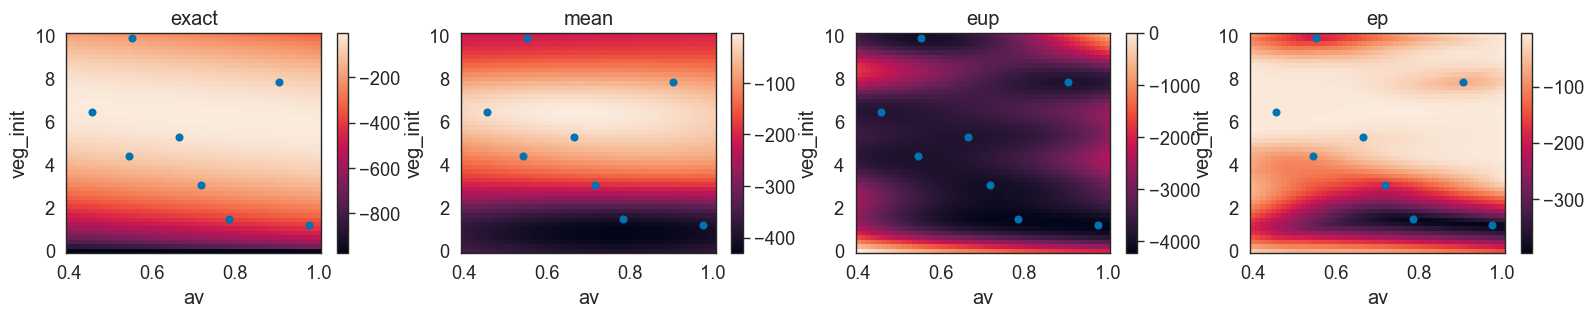

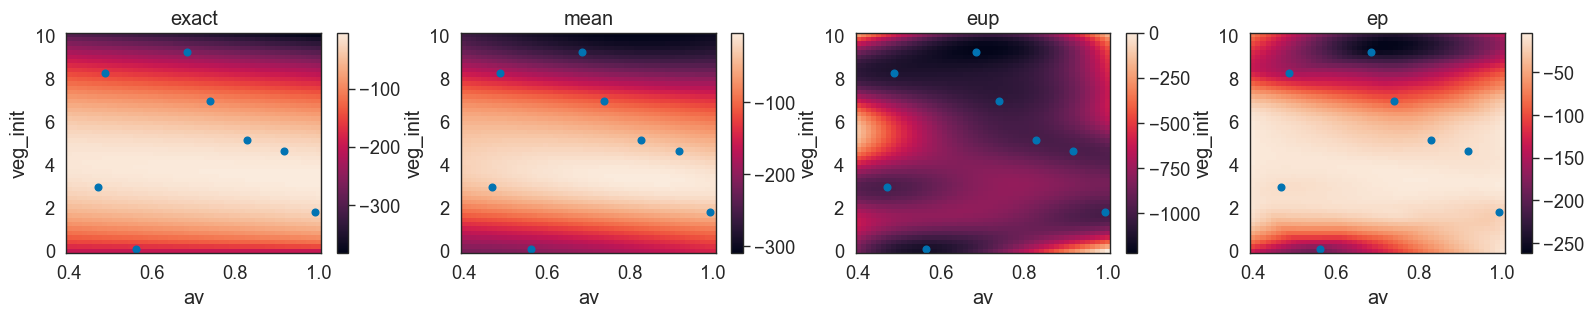

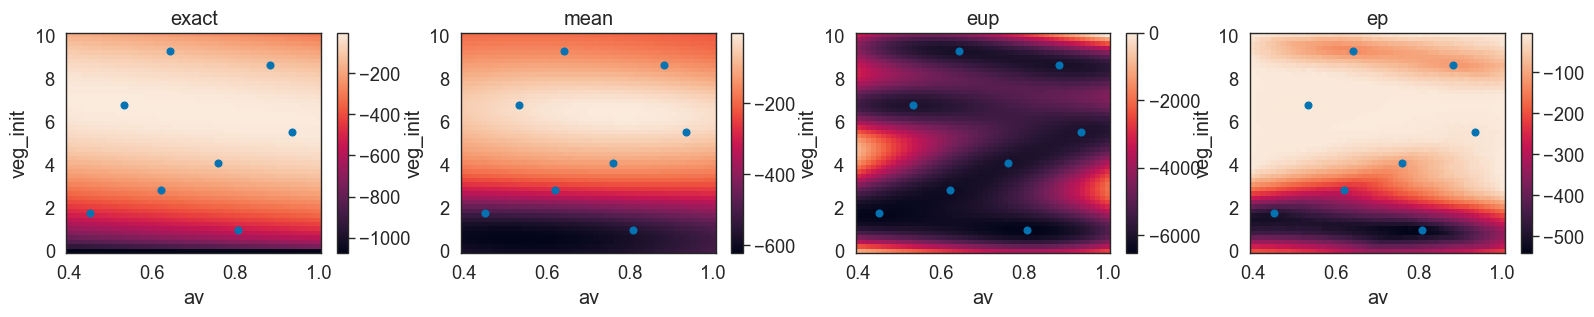

In [8]:
for rep in results_gp:
    rep.density_comparison.plot(normalized=True, log_scale=True,
                                max_cols=4, points=rep.surrogate_posterior_gp.surrogate.design.X)

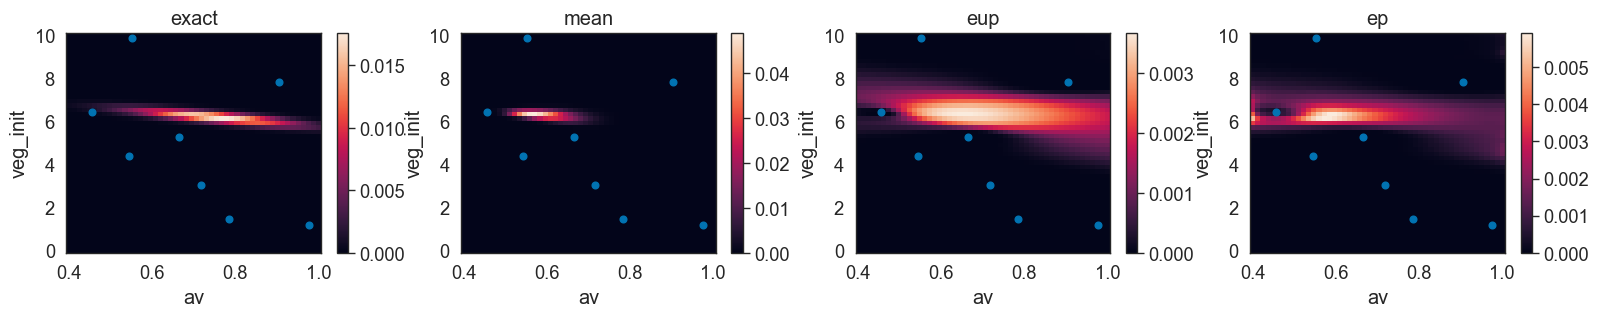

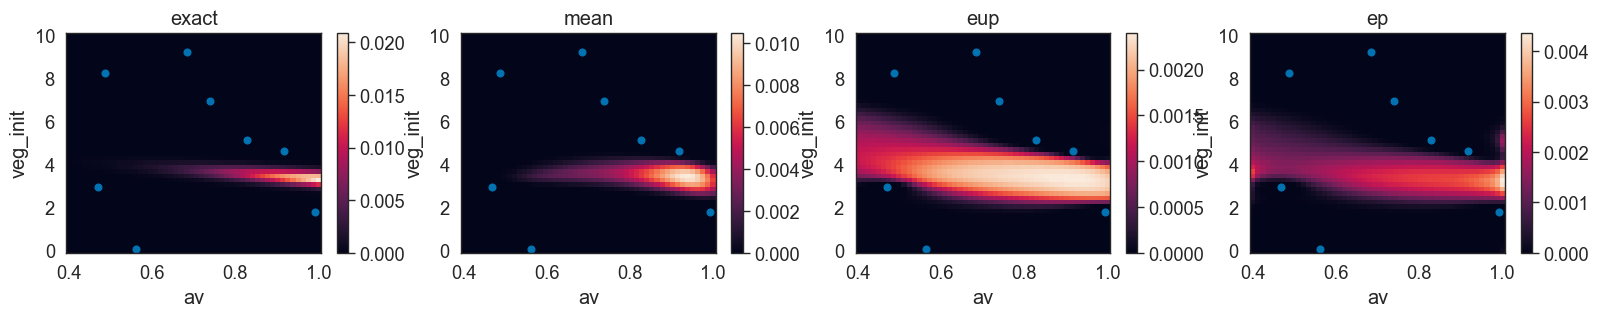

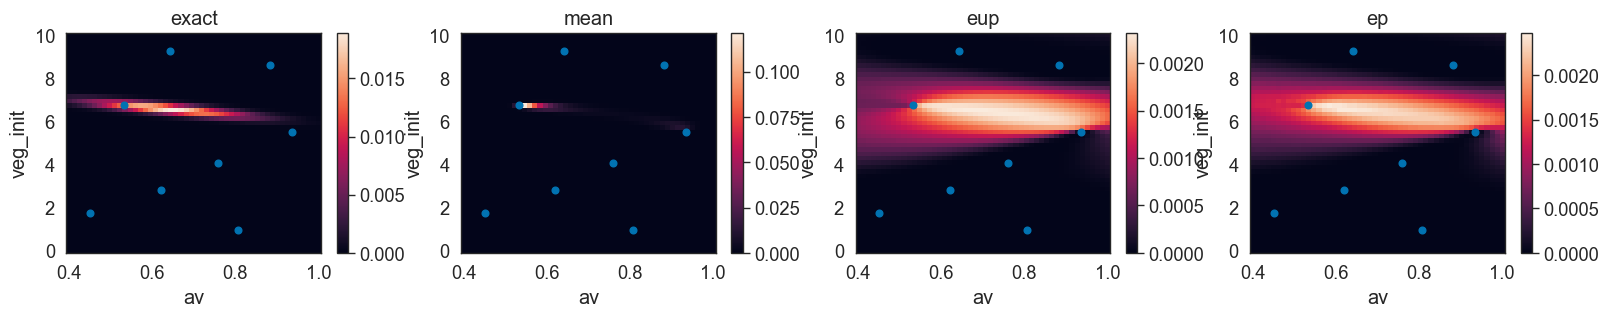

In [10]:
for rep in results_clip_gp:
    rep.density_comparison.plot(normalized=True, log_scale=False,
                                max_cols=4, points=rep.surrogate_posterior_clip_gp.surrogate.design.X)

In [ ]:
# summarize surrogate mean and sd
pred = surrogate_posterior.surrogate(grid.flat_grid)

grid.plot(z=pred.mean, title='surrogate mean', points=design.X)
grid.plot(z=jnp.sqrt(pred.variance), title='surrogate sd', points=design.X)

In [ ]:
# sampling posterior
key, key_mcmc = jr.split(key, 2)

samp = posterior.sample(key, n=3000, num_warmup_steps=500) # returns HMCState with samp.position (n, 1, 2)

plt.hist(samples[:,0])
plt.show()

In [ ]:
density_comparison.plot(['exact', 'mean', 'eup', 'ep'],
                         normalized=True, log_scale=False,
                         max_cols=4, points=design.X)

In [ ]:
from uncprop.utils.grid import get_grid_coverage_mask, plot_2d_mask

mask = get_grid_coverage_mask(log_prob=density_comparison.log_dens_norm_grid['ep'],
                              probs=jnp.linspace(0.1, 0.9, 30))

fig, ax = plot_2d_mask(mask, grid.shape, prob_idx=[0, 15, 20])

# TEMP

In [ ]:
import blackjax

In [ ]:
mwg_init_x = blackjax.rmh.init